<a href="https://colab.research.google.com/github/oenereaty/MP2024/blob/main/MP2024_wk9_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
#---#
import torch
import transformers
import tarfile

# with

## 기본사용

### 예제1: `__enter__` 와 `__exit__`

↓ context manager 를 찍어내는 Dummy 클래스



In [8]:
class Dummy:
    def __enter__(self):
        print("enter")
    def __exit__(self,*args): # *args는 에러처리 관련된 __exit__의 입력변수들.
                              # args를 받을 거라고 선언하지만 실제로 사용하지는 않음
        print("exit")

In [11]:
dir(d)

#__enter__ 와 __exit__가 존재함

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__']

In [5]:
d = Dummy()
d.__enter__()
print("context") # context를 출력함.
d.__exit__()

enter
context
exit


In [6]:
d = Dummy()
with d:
    print("context")

enter
context
exit


In [13]:
with 1:
  print("일단 시작해보자") # 오류 발생

AttributeError: __enter__

↓ 내가 만든 예시

In [17]:
class Dummy:
    def __enter__(self):
        print("교수님 ㅎㅇ")
    def __exit__(self,*args): # *args는 에러처리 관련된 __exit__의 입력변수들.
                              # args를 받을 거라고 선언하지만 실제로 사용하지는 않음
        print("교수님 ㅂㅇ")

d = Dummy()
with d:
  print("으왕")
  print("유튜브강의좀들어라수강생들아")

교수님 ㅎㅇ
으왕
유튜브강의좀들어라수강생들아
교수님 ㅂㅇ


`with` 뒤에 올 수 있는 오브젝트는 `__enter__` 와 `__exit__` 를 포함해야 한다

In [19]:
lst = [1,2,3]
with lst:
    pass

# 오류 발생 이유: `__enter__`도 없고 __exit__도 없어서

AttributeError: __enter__

In [20]:
dir(list)

['__add__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__rmul__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'append',
 'clear',
 'copy',
 'count',
 'extend',
 'index',
 'insert',
 'pop',
 'remove',
 'reverse',
 'sort']

### 예제2: `time`

원래 사용하던 패턴 (코드 실행되는 시간)

In [32]:
t1 = time.time()
np.random.randn(100,100) + 30
t2 = time.time()
t2-t1

0.0011227130889892578

이렇게도 사용할 수 있지 않을까?

In [36]:
class Timer:
    def __enter__(self):
        self.t1 = time.time()
    def __exit__(self,*args):
        self.t2 = time.time()
        print(f"{self.t2 - self.t1:.7f} 초 걸림")

In [41]:
with Timer():
    np.random.randn(100,100) + 30

# `__enter__ 와 `__exit__`가 있기 때문에 실행되는 class

0.0009418 초 걸림


In [46]:
set(dir(Timer))

{'__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__'}

### 예제3: 미분꼬리표 제거

In [57]:
class 미분꼬리표추적금지:
    def __enter__(self):
        torch.set_grad_enabled(False)
    def __exit__(self,*args):
        torch.set_grad_enabled(True)

In [48]:
a = torch.tensor(1.0,requires_grad = True)
a

tensor(1., requires_grad=True)

In [49]:
b = a+1
c = 2*b
d = c/3
b,c,d

(tensor(2., grad_fn=<AddBackward0>),
 tensor(4., grad_fn=<MulBackward0>),
 tensor(1.3333, grad_fn=<DivBackward0>))

In [58]:
with 미분꼬리표추적금지():
    b = a+1
    c = 2*b
    d = c/3
b,c,d

(tensor(2.), tensor(4.), tensor(1.3333))

### 예제4: 로짓 계산

In [59]:
model = transformers.AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2
)
model_input = {
    'input_ids': torch.tensor([[101, 2023, 3185, 2003, 6659, 2021, 2009, 2038, 2070, 2204, 3896, 1012, 102]]),
    'attention_mask': torch.tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
    'labels': torch.tensor([0])
}

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [60]:
logits = model(**model_input).logits
logits

tensor([[0.1596, 0.0012]], grad_fn=<AddmmBackward0>)

**예시1**

In [61]:
with 미분꼬리표추적금지():
    logits = model(**model_input).logits
    print(logits)

tensor([[0.1596, 0.0012]])


**예시2**

In [62]:
with torch.no_grad():
    logits = model(**model_input).logits
    print(logits)

tensor([[0.1596, 0.0012]])


In [63]:
dir(torch.no_grad)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'clone']

## 고급사용

### 예비사용

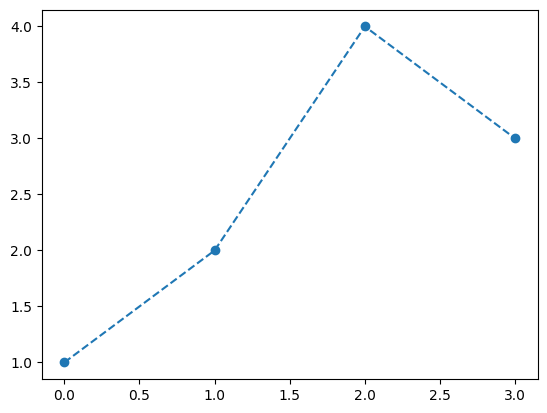

In [64]:
plt.plot([1,2,4,3],'--o')

사이즈가 마음에 들지 않아! 크기 조정(10,3)

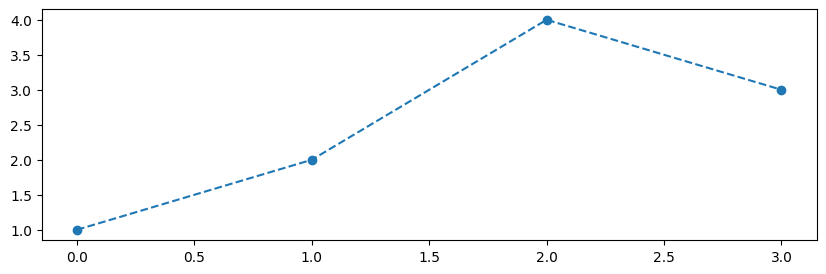

In [65]:
plt.rcParams['figure.figsize'] = [10, 3]
plt.plot([1,2,4,3],'--o')

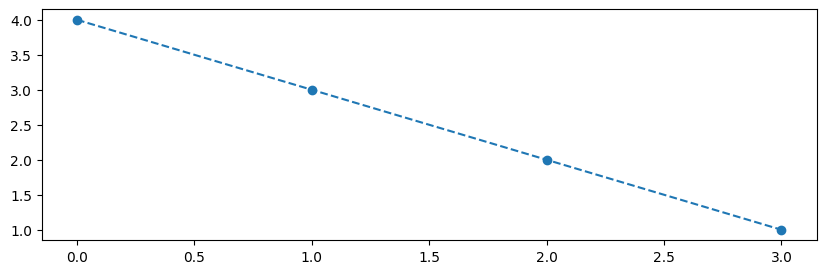

In [66]:
plt.plot([4,3,2,1],'--o')

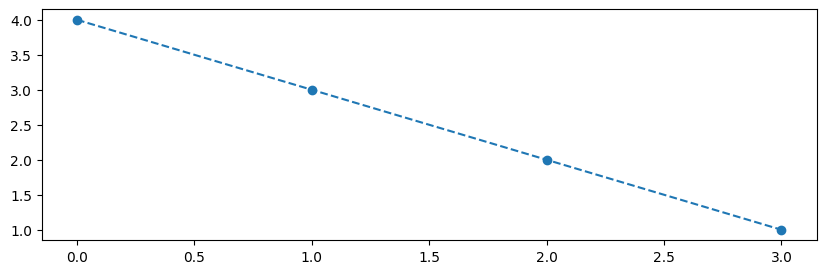

In [67]:
plt.plot([4,3,2,1],'--o')

⇑ 엥 나 [10,3] 사이즈 별론데

다시 되돌릴 수는 없을까?

In [69]:
plt.rcdefaults() # 방법1: 설정을 원래대로

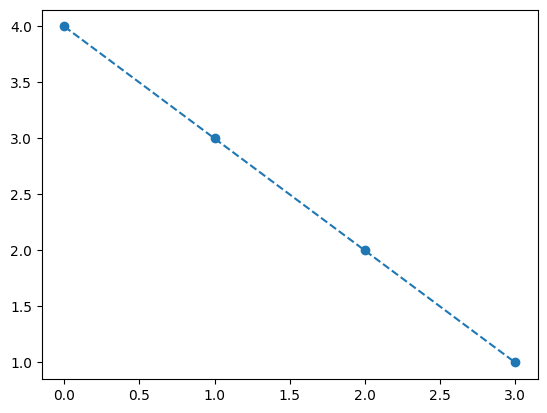

In [70]:
plt.plot([4,3,2,1],'--o')

### 예제1-1: 내 마음대로 크기 조정(`as` 無)

In [71]:
class FigureSizeContext:
    def __enter__(self):
        def resize(w,h):
            plt.rcParams['figure.figsize'] = [w, h]
        return resize
    def __exit__(self,*args):
        plt.rcdefaults()


코드 설명:

시작할 때(`__enter__`) 내 마음대로 크기 조정(`w`, `h`)을 한 후,

끝날 때? 코드 문 닫고 갈 때?(`__exit__`) `plt.rcdefaulsts()`를 실행함

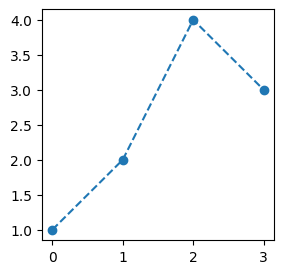

In [72]:
context_manager = FigureSizeContext()
xxxx = context_manager.__enter__()
xxxx(3,3)
plt.plot([1,2,4,3],'--o')
context_manager.__exit__()

⇑ 내 마음대로 크기 조정해야지~~

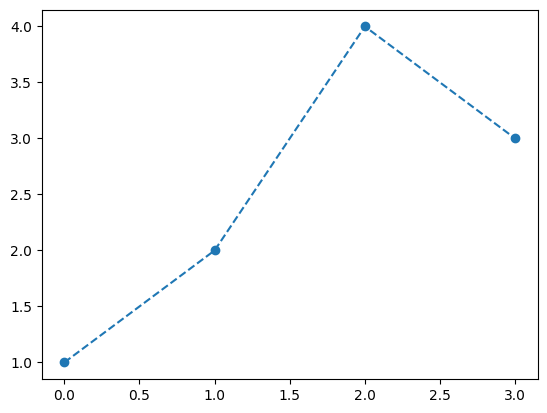

In [73]:
plt.plot([1,2,4,3],'--o')

⇑ 크기조정값이 없다면 디폴트 사이즈로 출력

### 예제1-2: 내 마음대로 크기 조정(`as` 有)

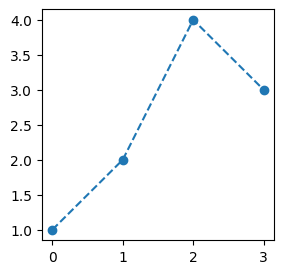

In [74]:
with FigureSizeContext() as xxxx:
    xxxx(3,3)
    plt.plot([1,2,4,3],'--o')

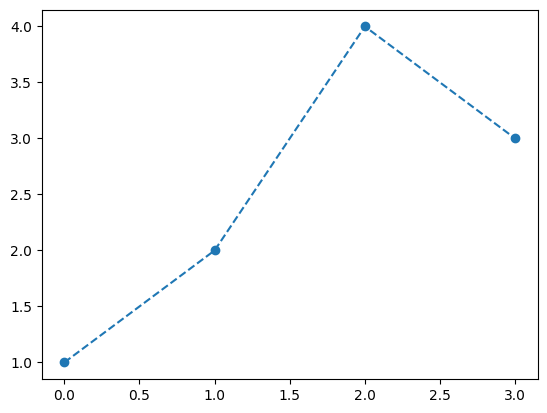

In [75]:
plt.plot([1,2,4,3],'--o')

### 정리

`with`는 아래와 같이 `as`와 함께 사용 가능하며

```python
with context_manager as xxxx:
    블라블라~
    야디야디~
```

여기에서 `as`뒤의 `xxxx` 자리는 `context_manager.__enter__`의 리턴값이 차지하게 된다.

In [76]:
class 미분꼬리표추적금지:
    def __enter__(self):
        torch.set_grad_enabled(False)
    def __exit__(self,*args):
        torch.set_grad_enabled(True)

In [79]:
class 미분꼬리표추적금지:
    def __enter__(self):
        torch.set_grad_enabled(False)
    def __exit__(self,*args):
        torch.set_grad_enabled(True)

In [81]:
with 미분꼬리표추적금지() as xxxx:
  print(xxxx)

# xxxx == None

None


### 예제2: 샌드위치 만들기

In [88]:
class 샌드위치생성기간소화:
  def __init__(self,빵="기본빵"):
    self.빵 = 빵
  def __enter__(self):
    print(f"---{self.빵}---")
  def __exit__(self, *args):
    print(f"---{self.빵}---")

In [90]:
with 샌드위치생성기간소화(빵='허니오트'):
  print("치즈")
  print("우왕")

---허니오트---
치즈
우왕
---허니오트---


In [97]:
class 샌드위치생성기:
  def __init__(self,빵="기본빵"):
    self.빵 = 빵
    self.재료들 = []
  def __enter__(self):
    print(f"---{self.빵}---")
    return self                   # 1st: "---{self.빵}---" 을 프린트
                                  # 2nd: `self`를 return
                                  # as 뒤의 xxxx 자리에 `__enter__`의 return 값이 들어가므로, xxxx == `샌드위치` -> self == `샌드위치`
  def __exit__(self, *args):
    print(f"---{self.빵}---")

  def 재료추가하기(self,재료):   # 3rd: `재료추가하기` 함수를 위해 새로운 함수를 정의한다. 여기서 `self`는 매개변수가 된다
    print(재료)
    self.재료들.append(재료)

In [98]:
with 샌드위치생성기(빵="허니오트") as 샌드위치:
    샌드위치.재료추가하기("양상추")
    샌드위치.재료추가하기("치즈")
    샌드위치.재료추가하기("베이컨")
    샌드위치.재료추가하기("오이")

---허니오트---
양상추
치즈
베이컨
오이
---허니오트---


In [99]:
샌드위치.빵, 샌드위치.재료들

('허니오트', ['양상추', '치즈', '베이컨', '오이'])

↓ 두 가지 코드가 동일한 기능을 수행한다

In [102]:
# 1st

with 샌드위치생성기(빵="허니오트") as 샌드위치:
    샌드위치.재료추가하기("토마토")
    샌드위치.재료추가하기("치즈")
    샌드위치.재료추가하기("베이컨")
    샌드위치.재료추가하기("에그마요")

---허니오트---
토마토
치즈
베이컨
에그마요
---허니오트---


In [104]:
# 2nd

샌드위치 = 샌드위치생성기(빵="허니오트")
샌드위치 = 샌드위치.__enter__()
샌드위치.재료추가하기("토마토")
샌드위치.재료추가하기("치즈")
샌드위치.재료추가하기("베이컨")
샌드위치.재료추가하기("에그마요")
샌드위치.__exit__()

---허니오트---
토마토
치즈
베이컨
에그마요
---허니오트---


따라서 `__enter__` 가 `self`를 리턴하는 경우에는

```python
with 샌드위치생성기(빵="허니오트") as 샌드위치
```

이 부분을 해석할 때`“샌드위치생성기(빵="허니오트")` 코드의 실행결과 만들어지는 오브젝트를 `샌드위치`로 저장”한다고 해석해도 무리가 없다.

```python
with 샌드위치생성기(빵="허니오트") as 샌드위치
```
           ^^^^^^^^^^^^^^^^^^^^^^^^^^ 이 부분이


```python
as 샌드위치
```

의 `샌드위치`에 저장한다고 볼 수 있다

### 예제3: example.txt

`example.txt` 를 만들고 "asdf” 라는 글자를 넣는 파이썬코드



In [110]:
with open("example.txt","w") as file:
    # 대충 해석: open("example.txt","w") 을 실행하여 나오는 오브젝트를 file로 받음
    # 왜냐하면 __enter__의 return값이 `self` 일 때만 해당하기 때문
    # 더 엄밀한 해석:
    # open("example.txt","w") 을 실행하여 나오는 오브젝트를 ???라고 하자.
    # 그런데 ??? 에는 `__enter__`가 있을텐데, 그 `__enter__`를 실행하여 나오는 오브젝트를
    # file로 받음.
    file.write("asdf")  `

In [106]:
file

<_io.TextIOWrapper name='example.txt' mode='w' encoding='UTF-8'>

In [107]:
context_manager = open("example.txt","w")
file = context_manager.__enter__()

In [111]:
type(context_manager), type(file)
# 두 개가 똑같다!

(_io.TextIOWrapper, _io.TextIOWrapper)

### 예제4: `tar.gz`로 압축

In [112]:
with tarfile.open("example.tar.gz","w:gz") as tar:
    tar.add("example.txt", arcname="example.txt")

분석하기

In [115]:
context_manager = tarfile.open("example.tar.gz","w:gz")
type(context_manager), type(tar)
# 똑같네용

(tarfile.TarFile, tarfile.TarFile)

`context_manager.__enter__()` 는 `self`를 리턴하는 것 같다